In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_train.json")

validation_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_validation.json")

test_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_test.json")

In [102]:
train_data.head()

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity
0,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7f317,https://www.reddit.com/r/relationships/comment...,Melodrama_,"It's a sad realization, isn't it?",,False,2,t1_cy7erc5,negative,1.000000
1,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hlyf,https://www.reddit.com/r/relationships/comment...,Melodrama_,I told her a couple of minutes ago that I didn...,elaboration,False,2,t1_cy7erc5,neutral,0.483631
2,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7etrr,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Leeches don't make good friends.,answer,False,1,t3_3xshx9,positive,0.600000
3,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hhpq,https://www.reddit.com/r/relationships/comment...,Melodrama_,I just ended it. Apparently she wasn't a good ...,elaboration,False,2,t1_cy7etrr,positive,0.475000
4,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7q0qg,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Good for you! Make sure you stick with it.,appreciation,False,3,t1_cy7hhpq,positive,0.744444


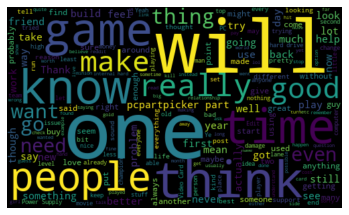

In [103]:
from wordcloud import WordCloud
%matplotlib inline
from matplotlib import pyplot as plt
allWords = ' '.join([a for a in train_data['body']])

wordcloud = WordCloud(width = 500 ,height =300 ,random_state = 21,max_font_size=120).generate(allWords)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()


Top polarity values


neutral          7679
positive         3231
negative          878
very positive     253
very negative      97
Name: sentiment.polarity, dtype: int64

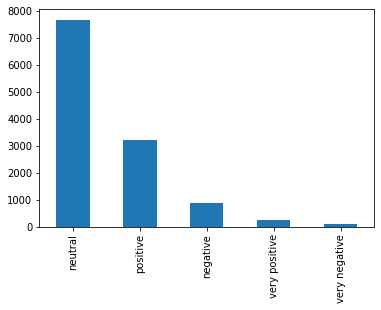

In [104]:
import numpy as np 
replaced_polarity = train_data.replace('', np.nan)
polarity = replaced_polarity['sentiment.polarity'].value_counts()
top_reviews = polarity.nlargest(10).plot.bar()
print('Top polarity values')
polarity

Top majority values


answer              5207
question            2016
elaboration         1638
appreciation         674
agreement            406
disagreement         356
humor                275
other                187
negativereaction     157
announcement         122
Name: majority_type, dtype: int64

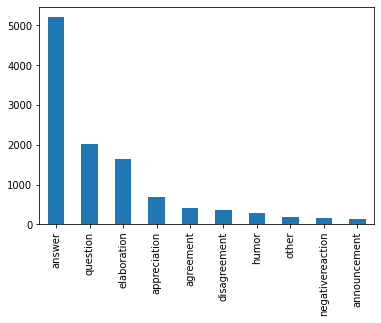

In [105]:
replaced_majority = train_data.replace('', np.nan)
majority = replaced_majority['majority_type'].value_counts()
top_majority = majority.nlargest(10).plot.bar()
print('Top majority values')
majority

## Data Preprocessing

### Making to lower

In [106]:
train_data = train_data.apply(lambda x: x.astype(str).str.lower())
validation_data = validation_data.apply(lambda x: x.astype(str).str.lower())
test_data = test_data.apply(lambda x: x.astype(str).str.lower())

### Removing Punctuations, Numbers, and Special Characters

In [107]:
# remove special characters, numbers, punctuations
train_data['body'] = train_data['body'].str.replace('[^a-zA-Z#]+',' ')
validation_data['body'] = validation_data['body'].str.replace('[^a-zA-Z#]+',' ')
test_data['body'] = test_data['body'].str.replace('[^a-zA-Z#]+',' ')

###  Removing Short Words

In [108]:
train_data['body'] = train_data['body'] .apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
validation_data['body'] = validation_data['body'] .apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
test_data['body'] = test_data['body'] .apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

### Tokenize and Normalize

In [109]:
import spacy

# Load the medium english model. 
# We will use this model to get embedding features for tokens later.
#!python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

# Download a stopword list
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [110]:
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    tokens.append(token)
  return tokens

#Normalize
def normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit)):
      normalized_tokens.append(normalized)
  return normalized_tokens
  return normalized_tokens

#Tokenize and normalize
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

### Removing Stopwords

In [111]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [112]:

train_data['body'].apply(lambda x: [item for item in x if item not in stop])
validation_data['body'].apply(lambda x: [item for item in x if item not in stop])
test_data['body'].apply(lambda x: [item for item in x if item not in stop])


0       [w,  , w, c, h, n, g,  , v,  , f, r,  , l,  , ...
1       [f, n,  , c, l,  , h,  , b, h,  , n,  , n,  , ...
2       [e, v, e, n,  , b, e, e, r,  , w, c, h,  , v, ...
3       [w, n,  , h,  , l,  , e, p, c,  , n,  , w, e, ...
4              [b, c, l, l,  , w, h,  , h, e,  , l, e,  ]
                              ...                        
4011    [u, p, e, r,  , g, c, u, l, u,  , h,  , p, w, ...
4012           [w, n,  , k, n, w,  , w, h, c, h,  , u, b]
4013    [h, e,  , p, w, e, r,  , l, g, c,  , r, c, h, ...
4014    [b, b, l, e,  , b, e, l,  , p, n, f, f,  , r, ...
4015    [b, e,  , r, e, l, g, n,  , l, v, e,  , w, u, ...
Name: body, Length: 4016, dtype: object

### One hot vectorizer

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

one_hot_vectorizer = CountVectorizer(tokenizer=tokenize_normalize, binary=True)
train_features = one_hot_vectorizer.fit_transform(train_data['body'])
validation_features = one_hot_vectorizer.transform(validation_data['body'])
test_features = one_hot_vectorizer.transform(test_data['body'])

In [113]:
train_labels = train_data['sentiment.polarity']
validation_labels = validation_data['sentiment.polarity']
test_labels = test_data['sentiment.polarity']

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels,average = 'weighted')
  recall = recall_score(predictions, true_labels,average = 'weighted')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1,average = 'weighted') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  a = classification_report(predictions, true_labels, digits=3, zero_division = 0)
  print(a)
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions)) # Note the order here is true, predicted


###  Dummy Classifier with strategy="most_frequent"


In [18]:
from sklearn.dummy import DummyClassifier

dummy_mf = DummyClassifier(strategy='most_frequent')
dummy_mf.fit(train_features, train_labels)
print(dummy_mf.score(validation_features, validation_labels))
evaluation_summary("Dummy Majority", dummy_mf.predict(validation_features), validation_labels)

0.6307494371180444
Evaluation for: Dummy Majority
Classifier 'Dummy Majority' has Acc=0.631 P=1.000 R=0.631 F1=0.774
               precision    recall  f1-score   support

     negative      0.000     0.000     0.000         0
      neutral      1.000     0.631     0.774      3109
     positive      0.000     0.000     0.000         0
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.631      3109
    macro avg      0.200     0.126     0.155      3109
 weighted avg      1.000     0.631     0.774      3109


Confusion matrix:
 [[   0  215    0    0    0]
 [   0 1961    0    0    0]
 [   0  845    0    0    0]
 [   0   15    0    0    0]
 [   0   73    0    0    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
print(dummy_mf.score(test_features, test_labels))
evaluation_summary("Dummy Majority", dummy_mf.predict(test_features), test_labels)

0.625996015936255
Evaluation for: Dummy Majority
Classifier 'Dummy Majority' has Acc=0.626 P=1.000 R=0.626 F1=0.770
               precision    recall  f1-score   support

     negative      0.000     0.000     0.000         0
      neutral      1.000     0.626     0.770      4016
     positive      0.000     0.000     0.000         0
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.626      4016
    macro avg      0.200     0.125     0.154      4016
 weighted avg      1.000     0.626     0.770      4016


Confusion matrix:
 [[   0  282    0    0    0]
 [   0 2514    0    0    0]
 [   0 1102    0    0    0]
 [   0   32    0    0    0]
 [   0   86    0    0    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Dummy Classifier with strategy="stratified"


In [20]:

dummy_prior = DummyClassifier(strategy='stratified')
dummy_prior.fit(train_features, train_labels)
print(dummy_prior.score(validation_features, validation_labels))
evaluation_summary("Dummy Prior", dummy_prior.predict(validation_features), validation_labels)

0.4889031843036346
Evaluation for: Dummy Prior
Classifier 'Dummy Prior' has Acc=0.476 P=0.477 R=0.476 F1=0.477
               precision    recall  f1-score   support

     negative      0.098     0.092     0.095       229
      neutral      0.632     0.627     0.630      1977
     positive      0.259     0.269     0.264       814
very negative      0.000     0.000     0.000        25
very positive      0.014     0.016     0.015        64

     accuracy                          0.476      3109
    macro avg      0.201     0.201     0.201      3109
 weighted avg      0.477     0.476     0.477      3109


Confusion matrix:
 [[  21  127   60    0    7]
 [ 142 1240  521   16   42]
 [  57  546  219    9   14]
 [   4   10    1    0    0]
 [   5   54   13    0    1]]


In [21]:
print(dummy_prior.score(test_features, test_labels))
evaluation_summary("Dummy Prior", dummy_prior.predict(test_features), test_labels)

0.47808764940239046
Evaluation for: Dummy Prior
Classifier 'Dummy Prior' has Acc=0.481 P=0.488 R=0.481 F1=0.484
               precision    recall  f1-score   support

     negative      0.103     0.092     0.097       314
      neutral      0.649     0.629     0.639      2593
     positive      0.243     0.270     0.256       993
very negative      0.000     0.000     0.000        22
very positive      0.012     0.011     0.011        94

     accuracy                          0.481      4016
    macro avg      0.201     0.200     0.201      4016
 weighted avg      0.488     0.481     0.484      4016


Confusion matrix:
 [[  29  164   81    2    6]
 [ 191 1632  618   17   56]
 [  87  713  268    3   31]
 [   1   22    9    0    0]
 [   6   62   17    0    1]]


### LogisticRegression with One-hot vectorization

In [114]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(train_features, train_labels)
print(lr_model.score(validation_features, validation_labels))
evaluation_summary("LR onehot", lr_model.predict(validation_features), validation_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7481505307172724
Evaluation for: LR onehot
Classifier 'LR onehot' has Acc=0.748 P=0.797 R=0.748 F1=0.766
               precision    recall  f1-score   support

     negative      0.233     0.526     0.323        95
      neutral      0.890     0.772     0.827      2261
     positive      0.604     0.710     0.653       718
very negative      0.133     0.500     0.211         4
very positive      0.247     0.581     0.346        31

     accuracy                          0.748      3109
    macro avg      0.421     0.618     0.472      3109
 weighted avg      0.797     0.748     0.766      3109


Confusion matrix:
 [[  50  157    7    1    0]
 [  41 1746  167    1    6]
 [   2  326  510    0    7]
 [   2   11    0    2    0]
 [   0   21   34    0   18]]


In [23]:
print(lr_model.score(test_features, test_labels))
evaluation_summary("LR onehot", lr_model.predict(test_features), test_labels)


0.7412848605577689
Evaluation for: LR onehot
Classifier 'LR onehot' has Acc=0.741 P=0.787 R=0.741 F1=0.759
               precision    recall  f1-score   support

     negative      0.227     0.467     0.305       137
      neutral      0.880     0.768     0.820      2881
     positive      0.614     0.714     0.660       948
very negative      0.062     0.667     0.114         3
very positive      0.256     0.468     0.331        47

     accuracy                          0.741      4016
    macro avg      0.408     0.617     0.446      4016
 weighted avg      0.787     0.741     0.759      4016


Confusion matrix:
 [[  64  212    5    1    0]
 [  64 2212  227    0   11]
 [   2  409  677    0   14]
 [   7   23    0    2    0]
 [   0   25   39    0   22]]


### TF-IDF VECTORIZER

In [24]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=tokenize_normalize,ngram_range=(1,2) , max_features=50000)

In [25]:
tfid_train_features = vectorizer.fit_transform(train_data['body'])
tfid_validation_features = vectorizer.fit_transform(validation_data['body'])
tfid_test_features = vectorizer.fit_transform(test_data['body'])

### LogisticRegression with TF-IDF vectorization

In [39]:
lr = LogisticRegression(C=1000)
tf_model = lr.fit(tfid_train_features,train_labels)
print(tf_model.score(tfid_validation_features, validation_labels))
evaluation_summary("LR TFIDF", tf_model.predict(tfid_validation_features), validation_labels) 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6095207462206498
Evaluation for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.610 P=0.896 R=0.610 F1=0.719
               precision    recall  f1-score   support

     negative      0.000     0.000     0.000         4
      neutral      0.944     0.629     0.755      2943
     positive      0.051     0.281     0.086       153
very negative      0.000     0.000     0.000         2
very positive      0.000     0.000     0.000         7

     accuracy                          0.610      3109
    macro avg      0.199     0.182     0.168      3109
 weighted avg      0.896     0.610     0.719      3109


Confusion matrix:
 [[   0  211    4    0    0]
 [   2 1852  102    0    5]
 [   2  797   43    1    2]
 [   0   14    1    0    0]
 [   0   69    3    1    0]]


In [40]:

print(tf_model.score(tfid_test_features, test_labels))
evaluation_summary("LR TFIDF", lr.predict(tfid_test_features), test_labels) 

0.6090637450199203
Evaluation for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.609 P=0.923 R=0.609 F1=0.729
               precision    recall  f1-score   support

     negative      0.011     0.250     0.020        12
      neutral      0.960     0.626     0.758      3855
     positive      0.026     0.238     0.047       122
very negative      0.000     0.000     0.000         9
very positive      0.000     0.000     0.000        18

     accuracy                          0.609      4016
    macro avg      0.199     0.223     0.165      4016
 weighted avg      0.923     0.609     0.729      4016


Confusion matrix:
 [[   3  264   12    1    2]
 [   7 2414   76    4   13]
 [   2 1065   29    3    3]
 [   0   30    2    0    0]
 [   0   82    3    1    0]]


### SVC Classifier with One-hot vectorization

In [29]:

from sklearn import svm
clf = svm.SVC(kernel = 'rbf')
clf_mod = clf.fit(train_features, train_labels)
print(clf_mod.score(validation_features, validation_labels))
evaluation_summary("SVM", clf_mod.predict(validation_features), validation_labels)

0.7272434866516565
Evaluation for: SVM
Classifier 'SVM' has Acc=0.727 P=0.856 R=0.727 F1=0.774
               precision    recall  f1-score   support

     negative      0.042     0.750     0.079        12
      neutral      0.942     0.727     0.821      2540
     positive      0.479     0.727     0.578       557
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.727      3109
    macro avg      0.293     0.441     0.296      3109
 weighted avg      0.856     0.727     0.774      3109


Confusion matrix:
 [[   9  202    4    0    0]
 [   1 1847  113    0    0]
 [   1  439  405    0    0]
 [   1   14    0    0    0]
 [   0   38   35    0    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print(clf_mod.score(test_features, test_labels))
evaluation_summary("SVM", clf_mod.predict(test_features), test_labels)

0.734312749003984
Evaluation for: SVM
Classifier 'SVM' has Acc=0.734 P=0.867 R=0.734 F1=0.783
               precision    recall  f1-score   support

     negative      0.032     0.643     0.061        14
      neutral      0.952     0.729     0.826      3283
     positive      0.496     0.761     0.601       719
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.734      4016
    macro avg      0.296     0.427     0.297      4016
 weighted avg      0.867     0.734     0.783      4016


Confusion matrix:
 [[   9  263   10    0    0]
 [   3 2393  118    0    0]
 [   0  555  547    0    0]
 [   2   30    0    0    0]
 [   0   42   44    0    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### An ‘interesting’ classifier model 

**"CATBOOST CLASSIFIER"**

In [31]:
!pip install catboost
!pip install ipywidgets

In [32]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

clf2 = CatBoostClassifier()
clf2_mod = clf2.fit(train_features, train_labels)
print(clf2_mod.score(validation_features, validation_labels))
evaluation_summary("Catboost", clf2_mod.predict(validation_features), validation_labels)


Learning rate set to 0.08987
0:	learn: 1.4911887	total: 444ms	remaining: 7m 23s
1:	learn: 1.4026801	total: 702ms	remaining: 5m 50s
2:	learn: 1.3285968	total: 957ms	remaining: 5m 17s
3:	learn: 1.2725864	total: 1.22s	remaining: 5m 4s
4:	learn: 1.2264530	total: 1.48s	remaining: 4m 54s
5:	learn: 1.1850430	total: 1.75s	remaining: 4m 49s
6:	learn: 1.1524973	total: 2s	remaining: 4m 44s
7:	learn: 1.1199950	total: 2.26s	remaining: 4m 40s
8:	learn: 1.0942746	total: 2.52s	remaining: 4m 37s
9:	learn: 1.0722873	total: 2.79s	remaining: 4m 36s
10:	learn: 1.0515198	total: 3.06s	remaining: 4m 34s
11:	learn: 1.0329918	total: 3.32s	remaining: 4m 33s
12:	learn: 1.0172194	total: 3.58s	remaining: 4m 31s
13:	learn: 1.0046293	total: 3.85s	remaining: 4m 30s
14:	learn: 0.9922682	total: 4.11s	remaining: 4m 29s
15:	learn: 0.9800569	total: 4.39s	remaining: 4m 30s
16:	learn: 0.9721106	total: 4.66s	remaining: 4m 29s
17:	learn: 0.9625891	total: 4.92s	remaining: 4m 28s
18:	learn: 0.9536146	total: 5.17s	remaining: 4m 2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
print(clf2_mod.score(test_features, test_labels))
evaluation_summary("Catboost", clf2_mod.predict(test_features), test_labels)

0.7280876494023905
Evaluation for: Catboost
Classifier 'Catboost' has Acc=0.728 P=0.834 R=0.728 F1=0.765
               precision    recall  f1-score   support

     negative      0.082     0.500     0.140        46
      neutral      0.929     0.731     0.818      3195
     positive      0.500     0.737     0.596       748
very negative      0.031     0.500     0.059         2
very positive      0.151     0.520     0.234        25

     accuracy                          0.728      4016
    macro avg      0.339     0.598     0.369      4016
 weighted avg      0.834     0.728     0.765      4016


Confusion matrix:
 [[  23  251    7    1    0]
 [  18 2336  156    0    4]
 [   0  543  551    0    8]
 [   5   26    0    1    0]
 [   0   39   34    0   13]]


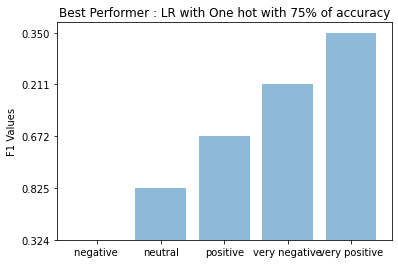

In [37]:
import matplotlib.pyplot as plt

objects = ('negative ','neutral','positive','very negative','very positive')
y_pos = np.arange(len(objects))
performance = ['0.324', '0.825',  '0.672',   '0.211'    ,'0.350' ]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('F1 Values')
plt.title('Best Performer : LR with One hot with 75% of accuracy')

plt.show()

### LogisticRegression with TF-IDF vectorization with parameter tuning 

In [34]:

vectorizerv = TfidfVectorizer(tokenizer=tokenize_normalize,ngram_range=(1,2) ,min_df=5, max_df=0.7, sublinear_tf=True,max_features=50000,stop_words = 'english',norm='l1')
tfidv_train_features = vectorizerv.fit_transform(train_data['body'])
tfidv_validation_features = vectorizerv.fit_transform(validation_data['body'])
tfidv_test_features = vectorizerv.fit_transform(test_data['body'])


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'nt'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [75]:
lr = LogisticRegression(solver='saga',max_iter=100 , C=1)
tfi_model = lr.fit(tfidv_train_features,train_labels)
print(tfi_model.score(tfidv_validation_features, validation_labels))
evaluation_summary("LR TFIDF PART 2", tfi_model.predict(tfidv_validation_features), validation_labels) 

0.6310710839498231
Evaluation for: LR TFIDF PART 2
Classifier 'LR TFIDF PART 2' has Acc=0.631 P=0.999 R=0.631 F1=0.773
               precision    recall  f1-score   support

     negative      0.000     0.000     0.000         0
      neutral      1.000     0.631     0.774      3107
     positive      0.001     0.500     0.002         2
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.631      3109
    macro avg      0.200     0.226     0.155      3109
 weighted avg      0.999     0.631     0.773      3109


Confusion matrix:
 [[   0  214    1    0    0]
 [   0 1961    0    0    0]
 [   0  844    1    0    0]
 [   0   15    0    0    0]
 [   0   73    0    0    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
print(tfi_model.score(tfidv_test_features, test_labels))
evaluation_summary("LR TFIDF", tfi_model.predict(tfidv_test_features), test_labels) 

0.6257470119521913
Evaluation for: LR TFIDF
Classifier 'LR TFIDF' has Acc=0.626 P=0.999 R=0.626 F1=0.770
               precision    recall  f1-score   support

     negative      0.000     0.000     0.000         0
      neutral      1.000     0.626     0.770      4015
     positive      0.000     0.000     0.000         1
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.626      4016
    macro avg      0.200     0.125     0.154      4016
 weighted avg      0.999     0.626     0.770      4016


Confusion matrix:
 [[   0  282    0    0    0]
 [   0 2513    1    0    0]
 [   0 1102    0    0    0]
 [   0   32    0    0    0]
 [   0   86    0    0    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




**Changes** :
Since TF-IDF vectorization method did not give good accuracy, I am using Countvectorization method

In [115]:
lr = LogisticRegression(C=1,solver='saga', max_iter = 100)
lr3 = lr.fit(train_features, train_labels)
print(lr3.score(validation_features, validation_labels))
evaluation_summary("LR", lr3.predict(validation_features), validation_labels)

0.7516886458668383
Evaluation for: LR
Classifier 'LR' has Acc=0.752 P=0.807 R=0.752 F1=0.771
               precision    recall  f1-score   support

     negative      0.233     0.588     0.333        85
      neutral      0.902     0.768     0.830      2302
     positive      0.588     0.720     0.648       690
very negative      0.067     0.333     0.111         3
very positive      0.274     0.690     0.392        29

     accuracy                          0.752      3109
    macro avg      0.413     0.620     0.463      3109
 weighted avg      0.807     0.752     0.771      3109


Confusion matrix:
 [[  50  158    7    0    0]
 [  30 1769  156    2    4]
 [   3  340  497    0    5]
 [   2   12    0    1    0]
 [   0   23   30    0   20]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [116]:
print(lr3.score(test_features, test_labels))
evaluation_summary("LR", lr3.predict(test_features), test_labels)

0.7470119521912351
Evaluation for: LR
Classifier 'LR' has Acc=0.747 P=0.799 R=0.747 F1=0.766
               precision    recall  f1-score   support

     negative      0.220     0.496     0.305       125
      neutral      0.892     0.768     0.825      2919
     positive      0.611     0.724     0.663       929
very negative      0.062     1.000     0.118         2
very positive      0.244     0.512     0.331        41

     accuracy                          0.747      4016
    macro avg      0.406     0.700     0.448      4016
 weighted avg      0.799     0.747     0.766      4016


Confusion matrix:
 [[  62  214    6    0    0]
 [  55 2242  209    0    8]
 [   2  415  673    0   12]
 [   6   24    0    2    0]
 [   0   24   41    0   21]]


**Change** : Instead of using multinomoial classes making it to binomial class will reduce computation time and provide higher accuracy

In [117]:
bi_train_data = train_data
bi_validation_data = validation_data
bi_test_data = test_data

In [118]:
bi_train_data

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity
0,relationships,my friend/crush [22/f] acting weird after i [2...,t1_cy7f317,https://www.reddit.com/r/relationships/comment...,melodrama_,sad realization isn,,false,2,t1_cy7erc5,negative,1.0
1,relationships,my friend/crush [22/f] acting weird after i [2...,t1_cy7hlyf,https://www.reddit.com/r/relationships/comment...,melodrama_,told her couple minutes ago that didn want con...,elaboration,false,2,t1_cy7erc5,neutral,0.48363095240000004
2,relationships,my friend/crush [22/f] acting weird after i [2...,t1_cy7etrr,https://www.reddit.com/r/relationships/comment...,treatyoselves,leeches don make good friends,answer,false,1,t3_3xshx9,positive,0.6000000000000001
3,relationships,my friend/crush [22/f] acting weird after i [2...,t1_cy7hhpq,https://www.reddit.com/r/relationships/comment...,melodrama_,just ended apparently she wasn good friend aft...,elaboration,false,2,t1_cy7etrr,positive,0.47500000000000003
4,relationships,my friend/crush [22/f] acting weird after i [2...,t1_cy7q0qg,https://www.reddit.com/r/relationships/comment...,treatyoselves,good for you make sure you stick with,appreciation,false,3,t1_cy7hhpq,positive,0.7444444444
...,...,...,...,...,...,...,...,...,...,...,...,...
12133,reddit.com,"if i announced myself as god right now, would ...",t1_c1zpyd0,https://www.reddit.com/r/reddit.com/comments/h...,,you were god you know whether would believe yo...,answer,false,1,t3_hzu51,neutral,0.0
12134,reddit.com,"if i announced myself as god right now, would ...",t1_c1zpz7m,https://www.reddit.com/r/reddit.com/comments/h...,thecannon,check account balance minutes and over will be...,answer,false,1,t3_hzu51,neutral,0.0
12135,reddit.com,"if i announced myself as god right now, would ...",t1_c1zq0tl,https://www.reddit.com/r/reddit.com/comments/h...,alllie,don know can you heal the sick with touch make...,answer,false,1,t3_hzu51,negative,0.637202381
12136,reddit.com,"if i announced myself as god right now, would ...",t1_c1zq19j,https://www.reddit.com/r/reddit.com/comments/h...,thecannon,give lebron james championship ring,humor,false,2,t1_c1zq0tl,neutral,0.0


In [122]:
bi_train_data['sentiment.polarity'] = bi_train_data['sentiment.polarity'].replace('positive',1)
bi_train_data['sentiment.polarity'] = bi_train_data['sentiment.polarity'].replace('neutral',1)
bi_train_data['sentiment.polarity'] = bi_train_data['sentiment.polarity'].replace('negative',0)
bi_train_data['sentiment.polarity'] = bi_train_data['sentiment.polarity'].replace('very positive',1)
bi_train_data['sentiment.polarity'] = bi_train_data['sentiment.polarity'].replace('very negative',0)


In [123]:
bi_validation_data['sentiment.polarity'] = bi_validation_data['sentiment.polarity'].replace('positive',1)
bi_validation_data['sentiment.polarity'] = bi_validation_data['sentiment.polarity'].replace('neutral',1)
bi_validation_data['sentiment.polarity'] = bi_validation_data['sentiment.polarity'].replace('negative',0)
bi_validation_data['sentiment.polarity'] = bi_validation_data['sentiment.polarity'].replace('very positive',1)
bi_validation_data['sentiment.polarity'] = bi_validation_data['sentiment.polarity'].replace('very negative',0)


In [124]:
bi_test_data['sentiment.polarity'] = bi_test_data['sentiment.polarity'].replace('positive',1)
bi_test_data['sentiment.polarity'] = bi_test_data['sentiment.polarity'].replace('neutral',1)
bi_test_data['sentiment.polarity'] = bi_test_data['sentiment.polarity'].replace('negative',0)
bi_test_data['sentiment.polarity'] = bi_test_data['sentiment.polarity'].replace('very positive',1)
bi_test_data['sentiment.polarity'] = bi_test_data['sentiment.polarity'].replace('very negative',0)


In [125]:
bi_test_data.head()

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity
0,starcraft,just a reminder on how much sc2 has evolved th...,t3_mqxoi,https://www.reddit.com/r/starcraft/comments/mq...,meisterkarl,was watching vod from last years dreamhack win...,question,true,0,,1,0.35000000000000003
1,starcraft,just a reminder on how much sc2 has evolved th...,t1_c334scx,https://www.reddit.com/r/starcraft/comments/mq...,smsy,find cool that both mana and naama made the th...,answer,false,1,t3_mqxoi,1,0.65
2,starcraft,just a reminder on how much sc2 has evolved th...,t1_c3354ny,https://www.reddit.com/r/starcraft/comments/mq...,vehemus,even better watch vod from mlg raleigh http ma...,agreement,false,1,t3_mqxoi,1,0.8
3,starcraft,just a reminder on how much sc2 has evolved th...,t1_c3356y6,https://www.reddit.com/r/starcraft/comments/mq...,nrujac,wasn that also epic and awesome series remembe...,,false,1,t3_mqxoi,1,0.5666666667
4,whowouldwin,your favorite hero now has a healing factor as...,t3_2ltpbr,https://www.reddit.com/r/whowouldwin/comments/...,,basically what the title says,question,true,0,,1,0.0


In [129]:
one_hot_vectorizer = CountVectorizer(tokenizer=tokenize_normalize, binary=True)

bi_train_data = bi_train_data[['body','sentiment.polarity']]
bi_validation_data = bi_validation_data[['body','sentiment.polarity']]
bi_test_data = bi_test_data[['body','sentiment.polarity']]

In [131]:

bi_train_features = one_hot_vectorizer.fit_transform(bi_train_data['body'])
bi_validation_features = one_hot_vectorizer.fit_transform(bi_validation_data['body'])
bi_test_features = one_hot_vectorizer.fit_transform(bi_test_data['body'])

In [132]:
bi_train_labels = bi_train_data['sentiment.polarity']
bi_test_labels = bi_test_data['sentiment.polarity']
bi_validation_labels = bi_validation_data['sentiment.polarity']

In [141]:
lr = LogisticRegression(C=1,solver='saga')
lr4 = lr.fit(bi_train_features, bi_train_labels)
print(lr4.score(validation_features, bi_validation_labels))
evaluation_summary("LR", lr.predict(validation_features), bi_validation_labels)

0.9366355741395948
Evaluation for: LR
Classifier 'LR' has Acc=0.937 P=0.971 R=0.937 F1=0.950
              precision    recall  f1-score   support

           0      0.257     0.694     0.375        85
           1      0.991     0.943     0.967      3024

    accuracy                          0.937      3109
   macro avg      0.624     0.819     0.671      3109
weighted avg      0.971     0.937     0.950      3109


Confusion matrix:
 [[  59  171]
 [  26 2853]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
  print(lr4.score(bi_test_features, bi_test_labels))
evaluation_summary("LR", lr4.predict(bi_test_features), bi_test_labels)

One more possibility or change which we can do is create a pipeline and predict with that

In [2]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# Use FeatureUnion to combine the features from text and summary
prediction_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('text', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('one-hot', CountVectorizer( binary=True)), 
              ])),
            ('majority', Pipeline([
              ('selector', ItemSelector(key='majority_type')),
              ('one-hot', CountVectorizer( binary=True)), 
              ])),
        ])
        )
    ])

NameError: name 'ItemSelector' is not defined

In [ ]:
one_hot_train_features = prediction_pipeline.fit_transform(train_data)
one_hot_validation_features = prediction_pipeline.transform(validation_data)
one_hot_test_features = prediction_pipeline.transform(test_data)

In [ ]:
lr = LogisticRegression(solver='saga')
combined_model = lr.fit(one_hot_train_features,train_labels)
evaluation_summary("LR", lr.predict(one_hot_validation_features), validation_labels)